In [150]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof
from bin_functions import bin_TS, select_basin
from eof_functions import compute_eof, proj_on_eof, plot_eof_basin
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

In [3]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)

## Read 4D annual means, select regions and bin

In [116]:
# -- Read all data in dask
datadir = '/data/ysilvy/CMIP5_annual/4D/'
# PiControl (multiple files)
dsT_piC = xr.open_mfdataset(datadir+'thetao*piControl*.nc',combine='by_coords',data_vars='minimal'
                            ,coords='minimal', compat='override',drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS_piC = xr.open_mfdataset(datadir+'so*piControl*.nc',combine='by_coords',data_vars='minimal'
                            ,coords='minimal', compat='override',drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# Ensemble mean hist+rcp85
dsT_ensm = xr.open_dataset(glob.glob(datadir+'thetao*ensm*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS_ensm = xr.open_dataset(glob.glob(datadir+'so*ensm*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# Hist+rcp85 members
dsT1 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r1i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS1 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r1i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT2 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r2i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS2 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r2i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT3 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r3i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS3 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r3i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsT4 = xr.open_dataset(glob.glob(datadir+'thetao*historical-rcp85_r4i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsS4 = xr.open_dataset(glob.glob(datadir+'so*historical-rcp85_r4i1p1*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
# 1pctCO2
dsTCO2 = xr.open_dataset(glob.glob(datadir+'thetao*1pctCO2*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])
dsSCO2 = xr.open_dataset(glob.glob(datadir+'so*1pctCO2*.nc')[0],chunks={'time':50},drop_variables=['lev_bnds','time_bnds','lat_vertices','lon_vertices'])

In [14]:
# -- Read volume (same for all experiments with IPSLCM5)
dirvol = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol = xr.open_dataset(dirvol+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol = dsvol.reindex(lev=list(dsT_piC.lev))
dsvol = dsvol.drop('j')
dsvol = dsvol.drop('i')
dsvol = dsvol.rename({'j': 'y','i': 'x'})

In [17]:
regions = ['southern_ocean','atlantic','pacific','indian']
# Read basin mask
mask = xr.open_dataset('/data/ysilvy/orca2_v2_subbasins_grid_T.nc').squeeze()

In [118]:
# -- Datasets containing 4 basins
dsT_ensm_reg = select_basin(dsT_ensm,mask)
dsS_ensm_reg = select_basin(dsS_ensm,mask)
dsT_piC_reg = select_basin(dsT_piC,mask)
dsS_piC_reg = select_basin(dsS_piC,mask)
dsT1_reg = select_basin(dsT1,mask)
dsS1_reg = select_basin(dsS1,mask)
dsT2_reg = select_basin(dsT2,mask)
dsS2_reg = select_basin(dsS2,mask)
dsT3_reg = select_basin(dsT3,mask)
dsS3_reg = select_basin(dsS3,mask)
dsT4_reg = select_basin(dsT4,mask)
dsS4_reg = select_basin(dsS4,mask)
dsTCO2_reg = select_basin(dsTCO2,mask)
dsSCO2_reg = select_basin(dsSCO2,mask)

In [124]:
# -- Bin in T/S volume
def bin_basins(S,T,vol,sbins,tbins):
    V_reg = ['']*4
    for i in range(4):
        V_reg[i] = bin_TS(S.isel(region=i),T.isel(region=i),vol,sbins,tbins)
    return V_reg

In [126]:
Vensm_reg = bin_basins(dsS_ensm_reg,dsT_ensm_reg,dsvol,sbins,tbins)
VpiC_reg = bin_basins(dsS_piC_reg,dsT_piC_reg,dsvol,sbins,tbins)
V1_reg = bin_basins(dsS1_reg,dsT1_reg,dsvol,sbins,tbins)
V2_reg = bin_basins(dsS2_reg,dsT2_reg,dsvol,sbins,tbins)
V3_reg = bin_basins(dsS3_reg,dsT3_reg,dsvol,sbins,tbins)
V4_reg = bin_basins(dsS4_reg,dsT4_reg,dsvol,sbins,tbins)
VCO2_reg = bin_basins(dsSCO2_reg,dsTCO2_reg,dsvol,sbins,tbins)

## EOFs: build a base from the ensemble mean and project others onto it

In [175]:
def plot_eof_basin(iregion,solver,pseudo_pcs_1,pseudo_pcs_2,pseudo_pcs_3,pseudo_pcs_4,
                  pseudo_pcs_piC1,pseudo_pcs_piC2,pseudo_pcs_piC3,pseudo_pcs_piC4,pseudo_pcs_CO2):

    pcs = solver.pcs()
    eofs = solver.eofs()
    var1 = solver.varianceFraction()[0].data*100
    var2 = solver.varianceFraction()[1].data*100
    var3 = solver.varianceFraction()[2].data*100
    eof1 = eofs[0,:].unstack('z')
    eof2 = -eofs[1,:].unstack('z')
    eof3 = -eofs[2,:].unstack('z')
 
    # -- Plot
    
    stdmax = np.max(np.array([pseudo_pcs_piC1[:,0].std(),pseudo_pcs_piC2[:,0].std(),pseudo_pcs_piC3[:,0].std(),pseudo_pcs_piC4[:,0].std()]))
    baseline = pcs[0:50,0].mean(dim='time')

    time=np.arange(1850,2101)
    timepiC = np.arange(1850,2100)
    timeCO2 = np.arange(1850,1990)
    
    fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

    vmin = -0.02 
    vmax = 0.02 

    c = eof1.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
    cb = fig.colorbar(c,ax=ax[0,0],label='')
    ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
    ax[0,1].plot(time,pcs[:,0],label='PC1',lw=2,color='black',zorder=10)
    ax[0,1].plot(time,pseudo_pcs_1[:,0],label='r1i1p1',zorder=9)
    ax[0,1].plot(time,pseudo_pcs_2[:,0],label='r2i1p1',zorder=8)
    ax[0,1].plot(time,pseudo_pcs_3[:,0],label='r3i1p1',zorder=7)
    ax[0,1].plot(time,pseudo_pcs_4[:,0],label='r4i1p1',zorder=6)
    ax[0,1].plot(timeCO2,pseudo_pcs_CO2[:,0],label='1pctCO2')
    ax[0,1].plot(timepiC,pseudo_pcs_piC1[:,0]-abs(baseline),color='grey',label='piControl - ensmean[1850-1900]',zorder=5)
    ax[0,1].plot(timepiC,pseudo_pcs_piC2[:,0]-abs(baseline),color='grey',zorder=4)
    ax[0,1].plot(timepiC,pseudo_pcs_piC3[:,0]-abs(baseline),color='grey',zorder=3)
    ax[0,1].plot(timepiC,pseudo_pcs_piC4[:,0]-abs(baseline),color='grey',zorder=2)
    ax[0,1].fill_between(x=time,y1=baseline-3*stdmax,y2=baseline+3*stdmax,alpha=0.5,color='grey',zorder=0)
    ax[0,1].legend()
    ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
    ax[0,1].set_title('PC1')
    ylim = ax[0,1].get_ylim()

    c = eof2.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
    cb = fig.colorbar(c,ax=ax[1,0],label='')
    ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
    ax[1,1].plot(time,-pcs[:,1],label='PC2',lw=2,color='black',zorder=10)
    ax[1,1].plot(time,-pseudo_pcs_1[:,1],label='r1i1p1')
    ax[1,1].plot(time,-pseudo_pcs_2[:,1],label='r2i1p1')
    ax[1,1].plot(time,-pseudo_pcs_3[:,1],label='r3i1p1')
    ax[1,1].plot(time,-pseudo_pcs_4[:,1],label='r4i1p1')
    ax[1,1].plot(timeCO2,-pseudo_pcs_CO2[:,1],label='1pctCO2')
    ax[1,1].plot(timepiC,-pseudo_pcs_piC1[:,1],color='grey',label='piControl')
    ax[1,1].plot(timepiC,-pseudo_pcs_piC2[:,1],color='grey')
    ax[1,1].plot(timepiC,-pseudo_pcs_piC3[:,1],color='grey')
    ax[1,1].plot(timepiC,-pseudo_pcs_piC4[:,1],color='grey')
    ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
    ax[1,1].set_title('PC2')
    ax[1,1].set_ylim(ylim[0],ylim[1])
    ax[1,1].legend()

    c = eof3.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
    cb = fig.colorbar(c,ax=ax[2,0],label='')
    ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
    ax[2,1].plot(time,-pcs[:,2],label='PC3',lw=2,color='black',zorder=10)
    ax[2,1].plot(time,-pseudo_pcs_1[:,2],label='r1i1p1')
    ax[2,1].plot(time,-pseudo_pcs_2[:,2],label='r2i1p1')
    ax[2,1].plot(time,-pseudo_pcs_3[:,2],label='r3i1p1')
    ax[2,1].plot(time,-pseudo_pcs_4[:,2],label='r4i1p1')
    ax[2,1].plot(timeCO2,-pseudo_pcs_CO2[:,2],label='1pctCO2')
    ax[2,1].plot(timepiC,-pseudo_pcs_piC1[:,2],color='grey',label='piControl')
    ax[2,1].plot(timepiC,-pseudo_pcs_piC2[:,2],color='grey')
    ax[2,1].plot(timepiC,-pseudo_pcs_piC3[:,2],color='grey')
    ax[2,1].plot(timepiC,-pseudo_pcs_piC4[:,2],color='grey')
    ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
    ax[2,1].set_title('PC3')
    ax[2,1].set_ylim(ylim[0],ylim[1])
    ax[2,1].legend()

    plt.subplots_adjust(hspace=0.25,wspace=0.08)
    title = regions[iregion]+'\n historical+rcp85 ensemble mean\nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)
    plt.suptitle(title,fontsize=14,fontweight='bold')
    plt.savefig('eof_ensmean_proj_'+regions[iregion]+'_'+str(deltaS)+'_'+str(deltaT)+'.png')

### Southern Ocean 

In [152]:
# -- EOF Ensemble mean
solver_so = compute_eof(Vensm_reg[0])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_so = proj_on_eof(V1_reg[0],solver_so)
pseudo_pcs_2_so = proj_on_eof(V2_reg[0],solver_so)
pseudo_pcs_3_so = proj_on_eof(V3_reg[0],solver_so)
pseudo_pcs_4_so = proj_on_eof(V4_reg[0],solver_so)

pseudo_pcs_piC1_so = proj_on_eof(VpiC_reg[0].isel(time=slice(0,250)),solver_so)
pseudo_pcs_piC2_so = proj_on_eof(VpiC_reg[0].isel(time=slice(250,500)),solver_so)
pseudo_pcs_piC3_so = proj_on_eof(VpiC_reg[0].isel(time=slice(500,750)),solver_so)
pseudo_pcs_piC4_so = proj_on_eof(VpiC_reg[0].isel(time=slice(750,1000)),solver_so)

pseudo_pcs_CO2_so = proj_on_eof(VCO2_reg[0],solver_so)

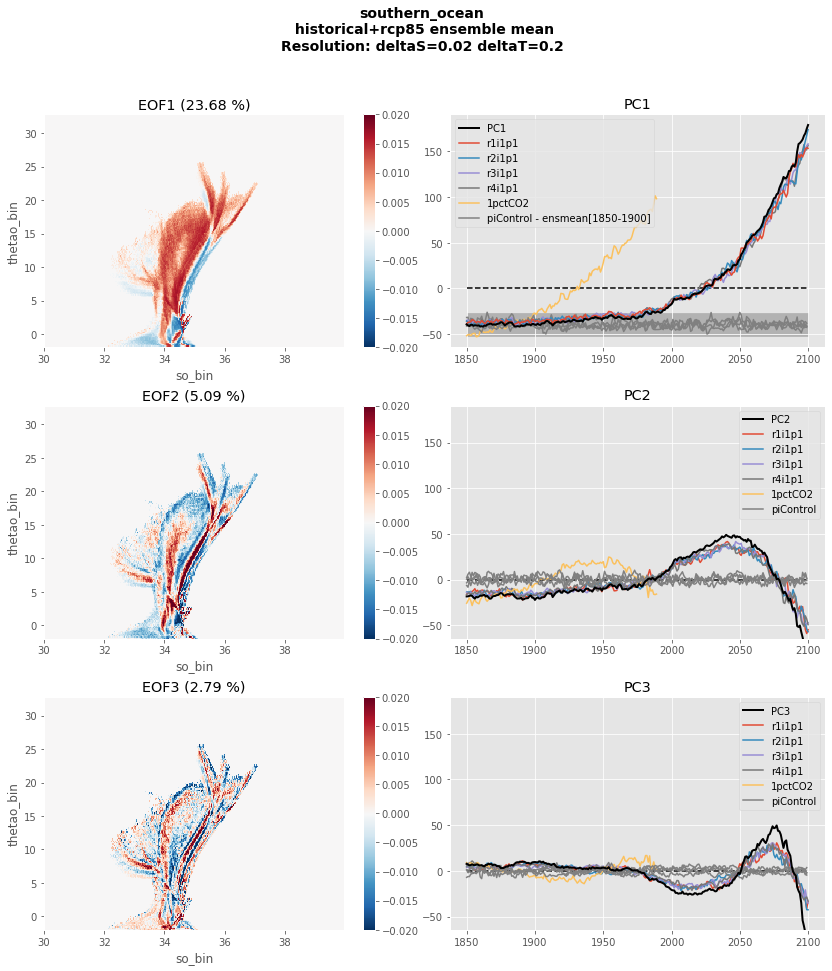

In [178]:
plot_eof_basin(0,solver_so,pseudo_pcs_1_so,pseudo_pcs_2_so,pseudo_pcs_3_so,pseudo_pcs_4_so,
                pseudo_pcs_piC1_so,pseudo_pcs_piC2_so,pseudo_pcs_piC3_so,pseudo_pcs_piC4_so,pseudo_pcs_CO2_so)

### Atlantic 

In [169]:
# -- EOF Ensemble mean
solver_atl = compute_eof(Vensm_reg[1])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_atl = proj_on_eof(V1_reg[1],solver_atl)
pseudo_pcs_2_atl = proj_on_eof(V2_reg[1],solver_atl)
pseudo_pcs_3_atl = proj_on_eof(V3_reg[1],solver_atl)
pseudo_pcs_4_atl = proj_on_eof(V4_reg[1],solver_atl)

pseudo_pcs_piC1_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(0,250)),solver_atl)
pseudo_pcs_piC2_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(250,500)),solver_atl)
pseudo_pcs_piC3_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(500,750)),solver_atl)
pseudo_pcs_piC4_atl = proj_on_eof(VpiC_reg[1].isel(time=slice(750,1000)),solver_atl)

pseudo_pcs_CO2_atl = proj_on_eof(VCO2_reg[1],solver_atl)

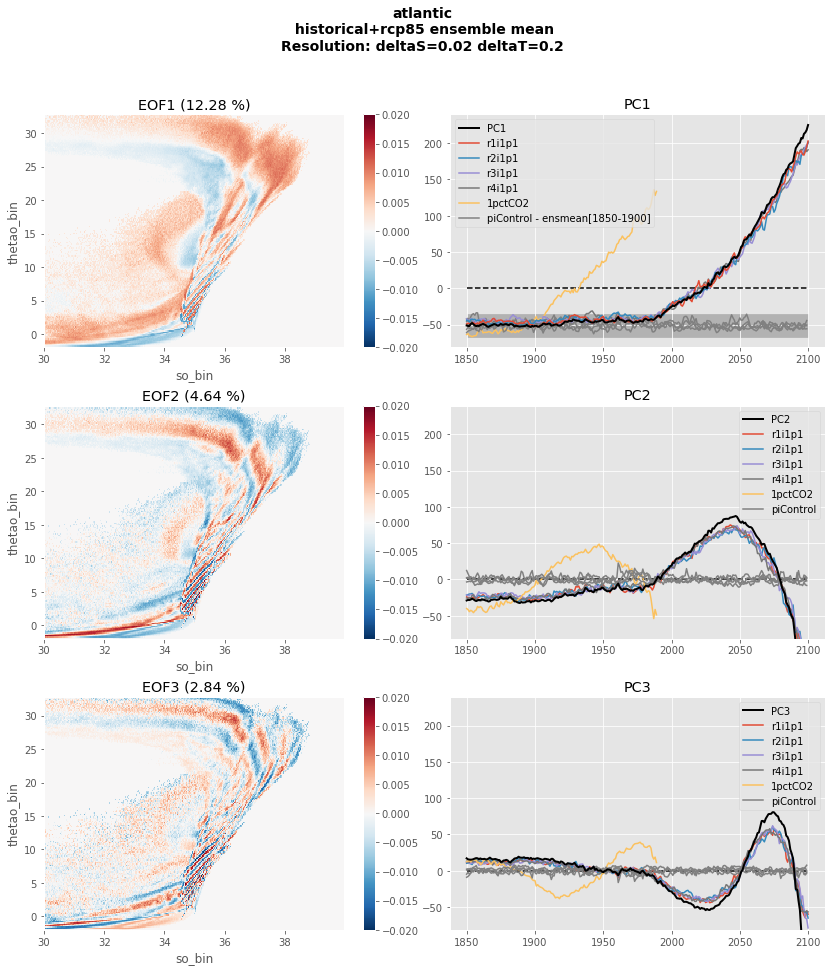

In [179]:
plot_eof_basin(1,solver_atl,pseudo_pcs_1_atl,pseudo_pcs_2_atl,pseudo_pcs_3_atl,pseudo_pcs_4_atl,
                pseudo_pcs_piC1_atl,pseudo_pcs_piC2_atl,pseudo_pcs_piC3_atl,pseudo_pcs_piC4_atl,pseudo_pcs_CO2_atl)

### Pacific 

In [173]:
# -- EOF Ensemble mean
solver_pac = compute_eof(Vensm_reg[2])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_pac = proj_on_eof(V1_reg[2],solver_pac)
pseudo_pcs_2_pac = proj_on_eof(V2_reg[2],solver_pac)
pseudo_pcs_3_pac = proj_on_eof(V3_reg[2],solver_pac)
pseudo_pcs_4_pac = proj_on_eof(V4_reg[2],solver_pac)

pseudo_pcs_piC1_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(0,250)),solver_pac)
pseudo_pcs_piC2_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(250,500)),solver_pac)
pseudo_pcs_piC3_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(500,750)),solver_pac)
pseudo_pcs_piC4_pac = proj_on_eof(VpiC_reg[2].isel(time=slice(750,1000)),solver_pac)

pseudo_pcs_CO2_pac = proj_on_eof(VCO2_reg[2],solver_pac)

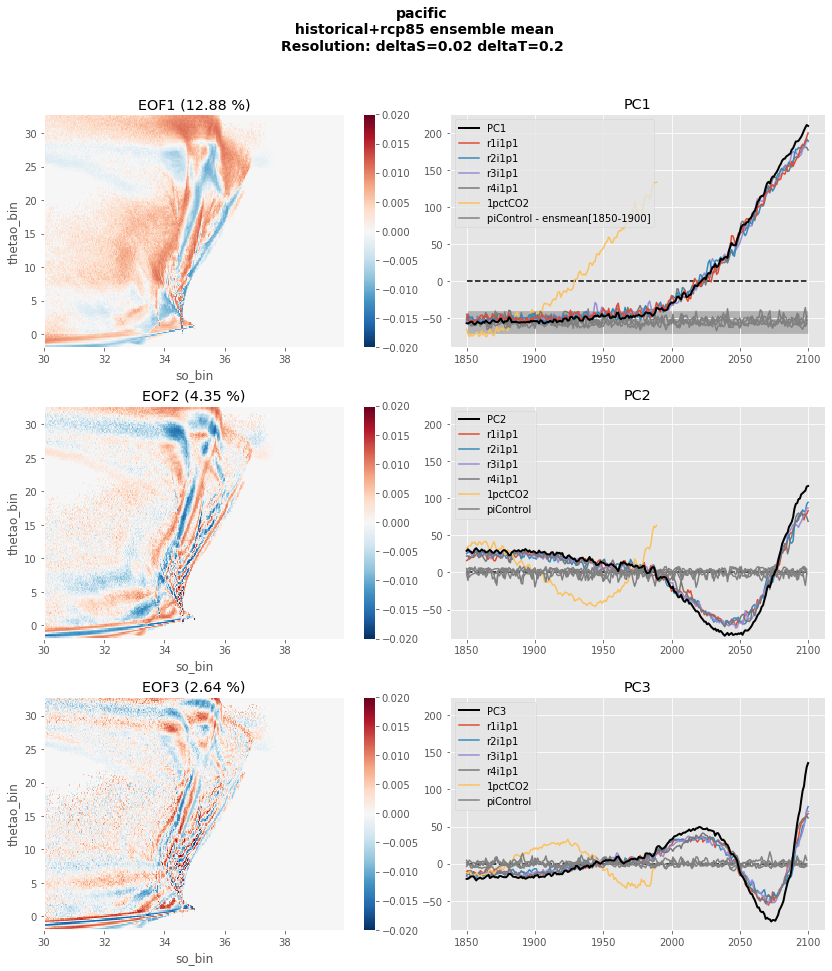

In [176]:
plot_eof_basin(2,solver_pac,pseudo_pcs_1_pac,pseudo_pcs_2_pac,pseudo_pcs_3_pac,pseudo_pcs_4_pac,
                pseudo_pcs_piC1_pac,pseudo_pcs_piC2_pac,pseudo_pcs_piC3_pac,pseudo_pcs_piC4_pac,pseudo_pcs_CO2_pac)

### Indian

In [180]:
# -- EOF Ensemble mean
solver_ind = compute_eof(Vensm_reg[3])
 # -- Project 4 members, piC and 1pctCO2
pseudo_pcs_1_ind = proj_on_eof(V1_reg[3],solver_ind)
pseudo_pcs_2_ind = proj_on_eof(V2_reg[3],solver_ind)
pseudo_pcs_3_ind = proj_on_eof(V3_reg[3],solver_ind)
pseudo_pcs_4_ind = proj_on_eof(V4_reg[3],solver_ind)

pseudo_pcs_piC1_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(0,250)),solver_ind)
pseudo_pcs_piC2_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(250,500)),solver_ind)
pseudo_pcs_piC3_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(500,750)),solver_ind)
pseudo_pcs_piC4_ind = proj_on_eof(VpiC_reg[3].isel(time=slice(750,1000)),solver_ind)

pseudo_pcs_CO2_ind = proj_on_eof(VCO2_reg[3],solver_ind)

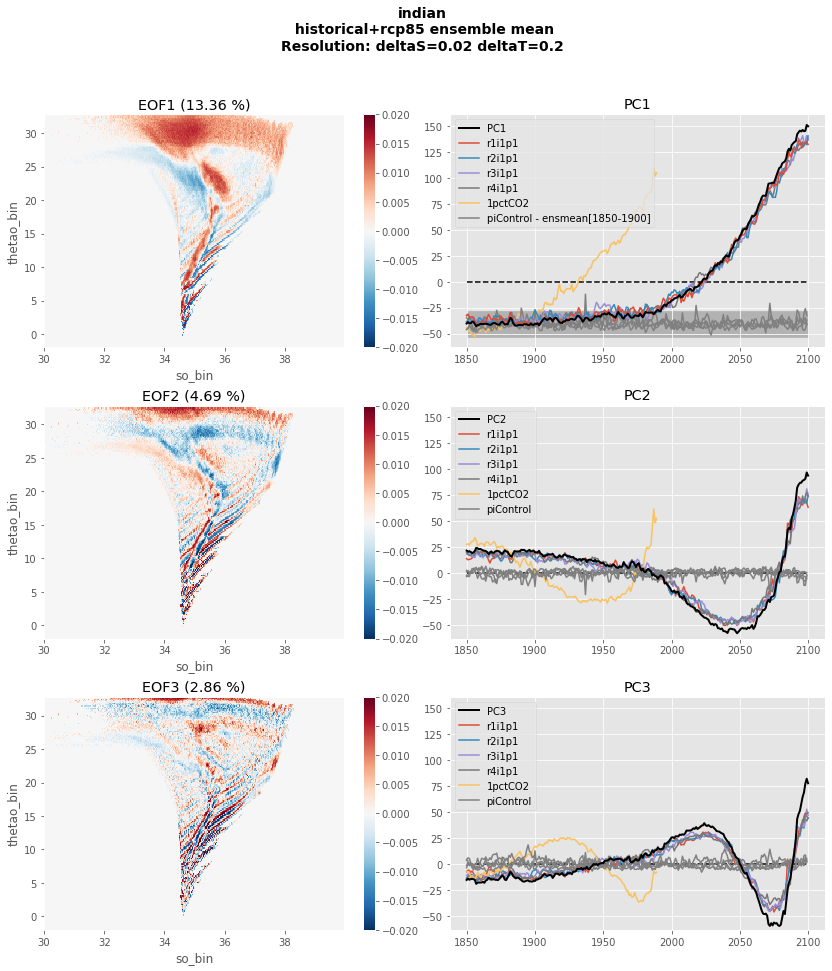

In [181]:
plot_eof_basin(3,solver_ind,pseudo_pcs_1_ind,pseudo_pcs_2_ind,pseudo_pcs_3_ind,pseudo_pcs_4_ind,
                pseudo_pcs_piC1_ind,pseudo_pcs_piC2_ind,pseudo_pcs_piC3_ind,pseudo_pcs_piC4_ind,pseudo_pcs_CO2_ind)